### Import needed libraries

In [38]:
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [39]:
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random

### Obtain list of all activities
Note: Obtain 'Authorization Code' first (see [README.md](./README.md))

In [40]:

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': "xxxxx",
    'client_secret': 'xxxxxx',
    'refresh_token': 'xxxxxxx',
    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

print("Requesting pages (200 activities per full page)...")
activities_df = pd.DataFrame()
page = 1
page_non_empty = True
while page_non_empty:
    header = {'Authorization': 'Bearer ' + access_token}
    param = {'per_page': 200, 'page': page}
    my_activities = requests.get(activites_url, headers=header, params=param).json()
    activities_df = activities_df.append(my_activities, ignore_index=True)
    page_non_empty = bool(my_activities)
    print(page)
    page += 1

print("\n", len(activities_df), "activities downloaded")

Requesting Token...

Access Token = a38c86399dd5aca559989ab226024dfd48a70134

Requesting pages (200 activities per full page)...
1
2
3
4
5

 613 activities downloaded


### Obtain list of trails for each activity

In [41]:
print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False) # auth_url & payload referenced in code already above
access_token = res.json()['access_token']
header = {'Authorization': 'Bearer ' + access_token}
print("Access Token = {}\n".format(access_token))

count = 0
print("Calculating time to get....\n")
for index, row in activities_df.iterrows():
    if row['type'] == 'Ride':
        count += 1
print(count * 8 / 60, " minutes to obtain data")

print("Getting trails for each activity")
activities_df['trails'] = None
for index, row in tqdm(activities_df.iterrows(), total=activities_df.shape[0]):
    get_activity_url = "https://www.strava.com/api/v3/activities/{}".format(row['id'])
    if row['type'] == 'Ride':
        activity_df = pd.DataFrame()
        try:
            my_activity = requests.get(get_activity_url, headers=header).json() 
            activity_df = pd.json_normalize(my_activity, record_path=['segment_efforts'])
            if len(activity_df.index) > 0:
                trail_list = activity_df['name'].tolist()
                activities_df.at[index, 'trails'] = trail_list
            time.sleep(random.randint(7, 9))
        except requests.exception.RequestException as e:
            raise SystemExit(e)

Requesting Token...

  0%|          | 0/613 [00:00<?, ?it/s]Access Token = a38c86399dd5aca559989ab226024dfd48a70134

Calculating time to get....

26.666666666666668  minutes to obtain data
Getting trails for each activity
100%|██████████| 613/613 [29:52<00:00,  2.92s/it]


### Unpack trail list and multiply rows
Thank you @alk & @Ian_Gow for this bad boy: 
https://stackoverflow.com/questions/21160134/flatten-a-column-with-value-of-type-list-while-duplicating-the-other-columns-va

In [42]:
def unnest(df, col, reset_index=False):
    col_flat = pd.DataFrame([[i, x] 
                       for i, y in df[col].apply(list).iteritems() 
                           for x in y], columns=['I', col])
    col_flat = col_flat.set_index('I')
    df = df.drop(col, 1)
    df = df.merge(col_flat, left_index=True, right_index=True)
    if reset_index:
        df = df.reset_index(drop=True)
    return df

In [43]:

# create unnested dataframe that removes entries with no trail data
activities_df_un = activities_df[activities_df['trails'].notnull()]

# actually unnest the dataframe
column = 'trails'
activities_df_un = unnest(activities_df_un, column)

# convert column to date time format for 
activities_df_un['date'] = pd.to_datetime(activities_df_un['start_date_local']).dt.date

activities_cols = ['date', 'trails']

activities_df_un = activities_df_un[activities_cols]

# save this dataframe to csv JIC
activities_df_un.to_csv('data/activities.csv') 

### Map the trails to number of jumps

In [44]:
# Got list of top 50 trails I ride and mapped number of jumps to trails
# activities_df_un['trails'].value_counts().head(50).to_csv('top_trails.csv')

# Modified file above to map the number of jumps and actual trail name
trail_jumps_df = pd.read_csv('data/trail_jumps.csv')

### Merge the two dataframes to get jumps per activity and saved to CSV

In [56]:
activity_jump_df = pd.merge(activities_df_un, trail_jumps_df, on=['trails'])

# save this dataframe to csv
activity_jump_df.to_csv('data/activity_jump.csv') 

In [57]:
# read activity and jump to use for data manipulation
activity_jump_df = pd.read_csv('data/activity_jump.csv')

<AxesSubplot:xlabel='date'>

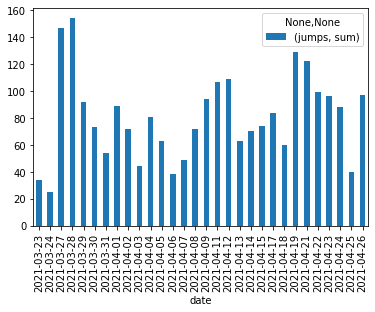

In [58]:
date_jump_df = activity_jump_df[['date', 'jumps']].groupby('date').agg(['sum'])
date_jump_df.tail(30).plot.bar()

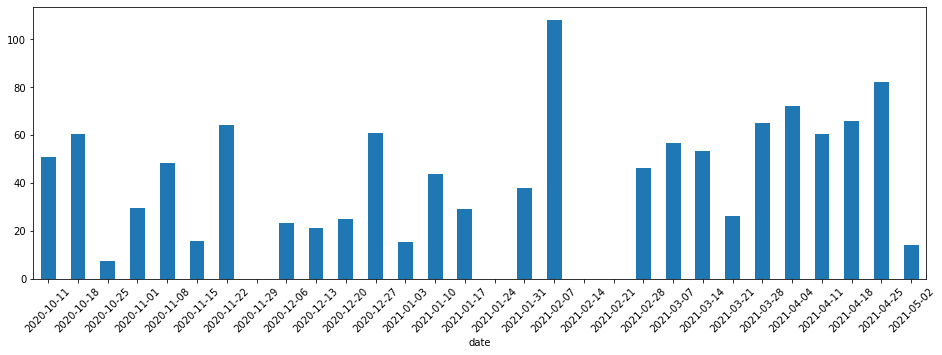

In [68]:
# format the date axis, thank you @xjcl and @Arleg
def line_format(label):
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

week_jump_df = activity_jump_df
week_jump_df.index = pd.to_datetime(week_jump_df['date'])
week_jump_df = week_jump_df.resample('W').sum()
week_jump_df['jumps'] = week_jump_df['jumps'] / 7
ax = week_jump_df['jumps'].tail(30).plot(kind='bar', figsize=(16,5))
ax.set_xticklabels([x.strftime("%Y-%m-%d") for x in week_jump_df.tail(30).index], rotation=45)
plt.show()